This is the python version used 
 

In [1]:
import sys
print(sys.version)

3.10.18 | packaged by Anaconda, Inc. | (main, Jun  5 2025, 13:08:55) [MSC v.1929 64 bit (AMD64)]


1.DenseNet121
2.SqueezeNetV2
3.EfficientNet-B0
4.Googlenet
5.VGG16

1) DenseNet121

Loading and preprocessing data...
Data preprocessing complete.
Training data shape: (48000, 32, 32, 3)
Validation data shape: (12000, 32, 32, 3)
Test submission data shape: (5000, 32, 32, 3)

Building the DenseNet121 model...

Compiling the model...
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 38, 38, 3)            0         ['input_3[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv1/conv (Conv2D)         (None, 16, 

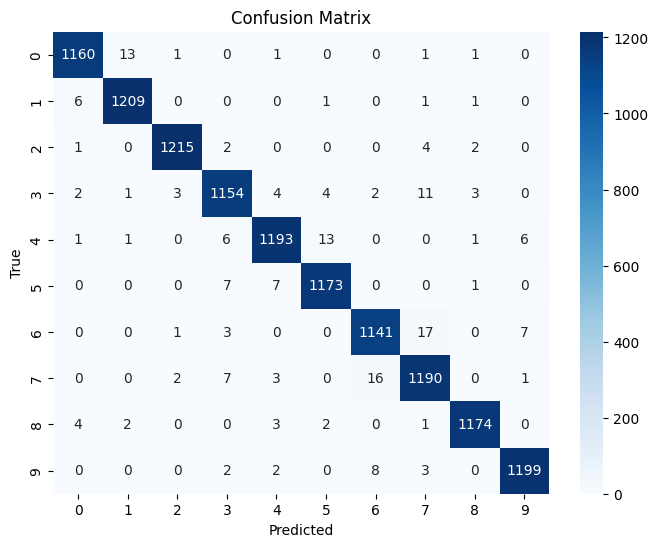

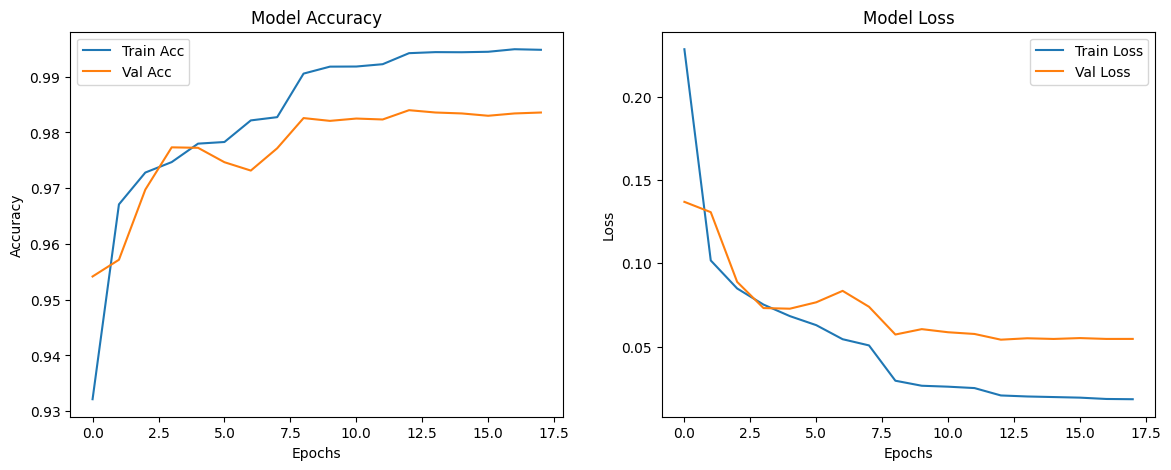

In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# --- 1. Data Loading and Preprocessing ---
print("Loading and preprocessing data...")

train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

X = train_df.drop('label', axis=1).values
y = train_df['label'].values
X_test_submission = test_df.drop('id', axis=1).values
test_ids = test_df['id'].values

X = X / 255.0
X_test_submission = X_test_submission / 255.0

X = X.reshape(-1, 28, 28, 1)
X_test_submission = X_test_submission.reshape(-1, 28, 28, 1)

# Resize to 32x32
X = tf.image.resize(X, (32, 32))
X_test_submission = tf.image.resize(X_test_submission, (32, 32))

# Convert from tensor to numpy
X = X.numpy()
X_test_submission = X_test_submission.numpy()

# Convert grayscale to RGB
X = np.repeat(X, 3, axis=-1)
X_test_submission = np.repeat(X_test_submission, 3, axis=-1)

y_categorical = to_categorical(y, num_classes=10)

X_train, X_val, y_train, y_val = train_test_split(
    X, y_categorical, test_size=0.2, random_state=42
)

print("Data preprocessing complete.")
print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")
print(f"Test submission data shape: {X_test_submission.shape}")

# --- 2. Build the DenseNet121 Model ---
print("\nBuilding the DenseNet121 model...")

input_tensor = Input(shape=(32, 32, 3))
base_model = DenseNet121(weights='imagenet', include_top=False, input_tensor=input_tensor)

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(10, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

# --- 3. Compile the Model ---
print("\nCompiling the model...")
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

# --- 4. Train the Model ---
print("\nTraining the model...")

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-5)

history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=64,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

# --- 5. Evaluate the Model ---
print("\nEvaluating model on validation set...")
val_loss, val_acc = model.evaluate(X_val, y_val, verbose=0)
print(f"Validation Accuracy: {val_acc:.4f}, Validation Loss: {val_loss:.4f}")

# Predictions
y_val_pred_probs = model.predict(X_val)
y_val_pred = np.argmax(y_val_pred_probs, axis=1)
y_val_true = np.argmax(y_val, axis=1)

# Accuracy Score
print(f"\nValidation Accuracy Score: {accuracy_score(y_val_true, y_val_pred):.4f}")

# Classification Report
print("\nClassification Report:")
print(classification_report(y_val_true, y_val_pred, digits=4))

# Confusion Matrix
cm = confusion_matrix(y_val_true, y_val_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), yticklabels=range(10))
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# --- 6. Plot Training Curves ---
plt.figure(figsize=(14,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()


2) Teacher - Student Model 
teacher model - DenseNet121

Loading and preprocessing data...
Data preprocessing complete.
Training data shape: (48000, 32, 32, 3)
Validation data shape: (12000, 32, 32, 3)
Test submission data shape: (5000, 32, 32, 3)

Building the Teacher (DenseNet121) model...
Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 zero_padding2d_2 (ZeroPadd  (None, 38, 38, 3)            0         ['input_7[0][0]']             
 ing2D)                                                                                           
                                                                                                  
 conv1/conv (Conv2D)         (None, 16, 16, 64)       

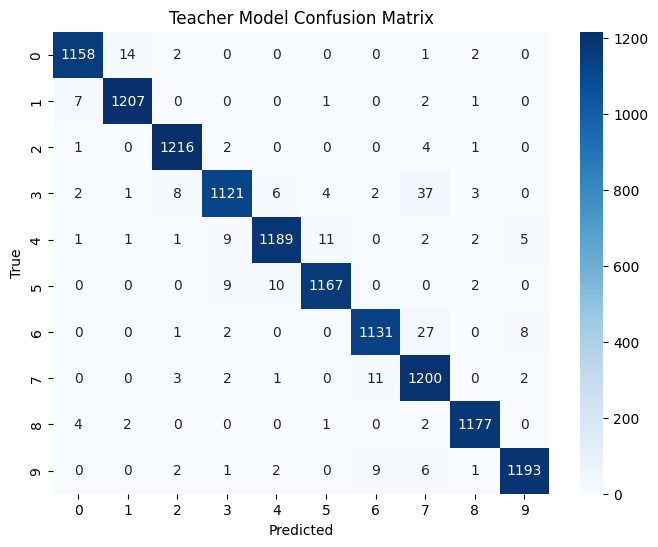


Evaluating Student model...
375/375 [==============================] - 4s 9ms/step
Student Accuracy: 0.9941

Student Classification Report:
              precision    recall  f1-score   support

           0     0.9983    0.9822    0.9901      1177
           1     0.9838    1.0000    0.9919      1218
           2     0.9976    0.9992    0.9984      1224
           3     0.9941    0.9916    0.9928      1184
           4     0.9984    0.9967    0.9975      1221
           5     0.9975    0.9975    0.9975      1188
           6     0.9864    0.9949    0.9906      1169
           7     0.9910    0.9902    0.9906      1219
           8     0.9958    1.0000    0.9979      1186
           9     0.9983    0.9885    0.9934      1214

    accuracy                         0.9941     12000
   macro avg     0.9941    0.9941    0.9941     12000
weighted avg     0.9941    0.9941    0.9941     12000



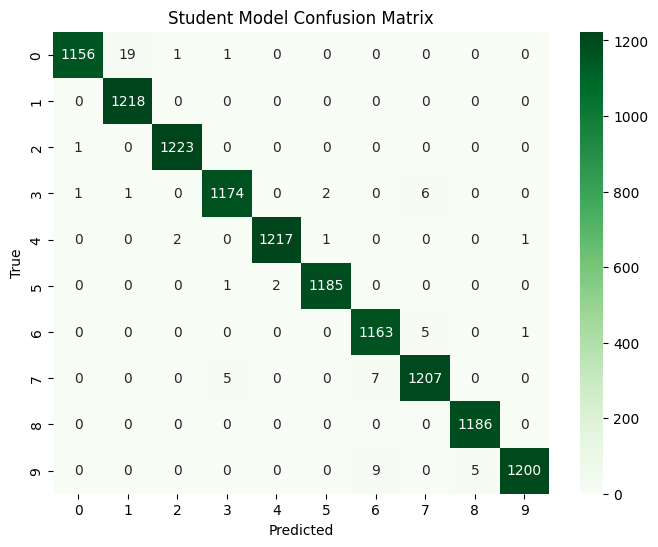

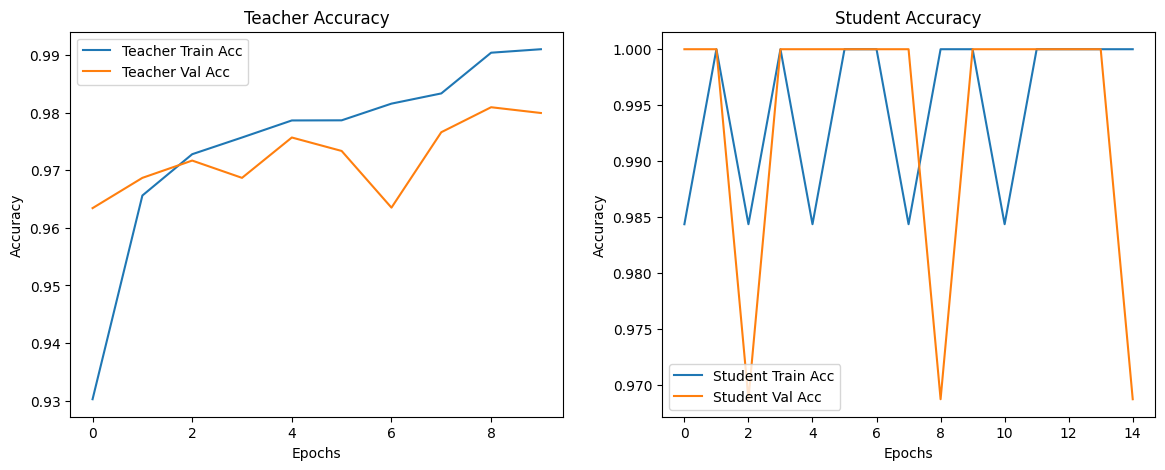

In [8]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tensorflow.keras.losses import CategoricalCrossentropy, KLDivergence

# --- 1. Data Loading and Preprocessing ---
print("Loading and preprocessing data...")

train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

X = train_df.drop('label', axis=1).values
y = train_df['label'].values
X_test_submission = test_df.drop('id', axis=1).values
test_ids = test_df['id'].values

# Normalize
X = X / 255.0
X_test_submission = X_test_submission / 255.0

# Reshape to images
X = X.reshape(-1, 28, 28, 1)
X_test_submission = X_test_submission.reshape(-1, 28, 28, 1)

# Resize to 32x32
X = tf.image.resize(X, (32, 32))
X_test_submission = tf.image.resize(X_test_submission, (32, 32))

# Convert tensor to numpy
X = X.numpy()
X_test_submission = X_test_submission.numpy()

# Convert grayscale → RGB
X = np.repeat(X, 3, axis=-1)
X_test_submission = np.repeat(X_test_submission, 3, axis=-1)

# One-hot labels
y_categorical = to_categorical(y, num_classes=10)

X_train, X_val, y_train, y_val = train_test_split(
    X, y_categorical, test_size=0.2, random_state=42
)

print("Data preprocessing complete.")
print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")
print(f"Test submission data shape: {X_test_submission.shape}")

# --- 2. Teacher Model: DenseNet121 ---
print("\nBuilding the Teacher (DenseNet121) model...")

input_tensor = Input(shape=(32, 32, 3))
base_model = DenseNet121(weights='imagenet', include_top=False, input_tensor=input_tensor)

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(10, activation='softmax')(x)

teacher_model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

teacher_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

teacher_model.summary()

# Train teacher
print("\nTraining Teacher model...")
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-5)

history_teacher = teacher_model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=64,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

# --- 3. Student Model ---
print("\nBuilding Student model (small CNN)...")

def build_student_model(input_shape=(32, 32, 3), num_classes=10):
    inputs = Input(shape=input_shape)
    x = Conv2D(32, (3,3), activation='relu', padding='same')(inputs)
    x = MaxPooling2D()(x)
    x = Conv2D(64, (3,3), activation='relu', padding='same')(x)
    x = MaxPooling2D()(x)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    return Model(inputs, outputs, name="student_model")

student_model = build_student_model()
student_model.summary()

# --- 4. Knowledge Distillation Setup ---
class Distiller(Model):
    def __init__(self, student, teacher, temperature=5.0, alpha=0.5):
        super(Distiller, self).__init__()
        self.student = student
        self.teacher = teacher
        self.temperature = temperature
        self.alpha = alpha
        self.student_loss_fn = CategoricalCrossentropy()
        self.distill_loss_fn = KLDivergence()

    def compile(self, optimizer, metrics):
        super(Distiller, self).compile(optimizer=optimizer, metrics=metrics)

    def train_step(self, data):
        x, y = data
        teacher_preds = self.teacher(x, training=False)

        with tf.GradientTape() as tape:
            student_preds = self.student(x, training=True)

            # Hard loss
            student_loss = self.student_loss_fn(y, student_preds)

            # Soft loss (with temperature scaling)
            teacher_soft = tf.nn.softmax(teacher_preds / self.temperature, axis=1)
            student_soft = tf.nn.softmax(student_preds / self.temperature, axis=1)
            distill_loss = self.distill_loss_fn(teacher_soft, student_soft)

            # Combine losses
            loss = self.alpha * student_loss + (1 - self.alpha) * distill_loss

        gradients = tape.gradient(loss, self.student.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.student.trainable_variables))

        acc = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(student_preds, 1), tf.argmax(y, 1)), tf.float32))
        return {"loss": loss, "student_loss": student_loss, "distill_loss": distill_loss, "accuracy": acc}

    def test_step(self, data):
        x, y = data
        student_preds = self.student(x, training=False)
        loss = self.student_loss_fn(y, student_preds)
        acc = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(student_preds, 1), tf.argmax(y, 1)), tf.float32))
        return {"loss": loss, "accuracy": acc}

# --- 5. Train Student with Teacher Guidance ---
print("\nTraining Student model with Distillation...")

distiller = Distiller(student=student_model, teacher=teacher_model, temperature=5.0, alpha=0.5)
distiller.compile(optimizer=Adam(1e-3), metrics=['accuracy'])

history_student = distiller.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=15,
    batch_size=64,
    verbose=1
)

# --- 6. Evaluate Teacher and Student ---
print("\nEvaluating Teacher model...")
y_val_pred_teacher = np.argmax(teacher_model.predict(X_val), axis=1)
y_val_true = np.argmax(y_val, axis=1)
print(f"Teacher Accuracy: {accuracy_score(y_val_true, y_val_pred_teacher):.4f}")
print("\nTeacher Classification Report:")
print(classification_report(y_val_true, y_val_pred_teacher, digits=4))

cm_teacher = confusion_matrix(y_val_true, y_val_pred_teacher)
plt.figure(figsize=(8,6))
sns.heatmap(cm_teacher, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), yticklabels=range(10))
plt.title("Teacher Model Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

print("\nEvaluating Student model...")
y_val_pred_student = np.argmax(student_model.predict(X_val), axis=1)
print(f"Student Accuracy: {accuracy_score(y_val_true, y_val_pred_student):.4f}")
print("\nStudent Classification Report:")
print(classification_report(y_val_true, y_val_pred_student, digits=4))

cm_student = confusion_matrix(y_val_true, y_val_pred_student)
plt.figure(figsize=(8,6))
sns.heatmap(cm_student, annot=True, fmt="d", cmap="Greens", xticklabels=range(10), yticklabels=range(10))
plt.title("Student Model Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# --- 7. Plot Training Curves ---
plt.figure(figsize=(14,5))

plt.subplot(1,2,1)
plt.plot(history_teacher.history['accuracy'], label='Teacher Train Acc')
plt.plot(history_teacher.history['val_accuracy'], label='Teacher Val Acc')
plt.title("Teacher Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history_student.history['accuracy'], label='Student Train Acc')
plt.plot(history_student.history['val_accuracy'], label='Student Val Acc')
plt.title("Student Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.show()


3) SqueezeNetV2

Loading and preprocessing data...
Data preprocessing complete.
Training data shape: (48000, 32, 32, 3)
Validation data shape: (12000, 32, 32, 3)
Test submission data shape: (5000, 32, 32, 3)

Building the SqueezeNetV2 model...

Compiling the model...
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 conv2d_114 (Conv2D)         (None, 16, 16, 64)           1792      ['input_4[0][0]']             
                                                                                                  
 max_pooling2d_26 (MaxPooli  (None, 8, 8, 64)             0         ['conv2d_114[0][0]']          
 ng2D)                                 

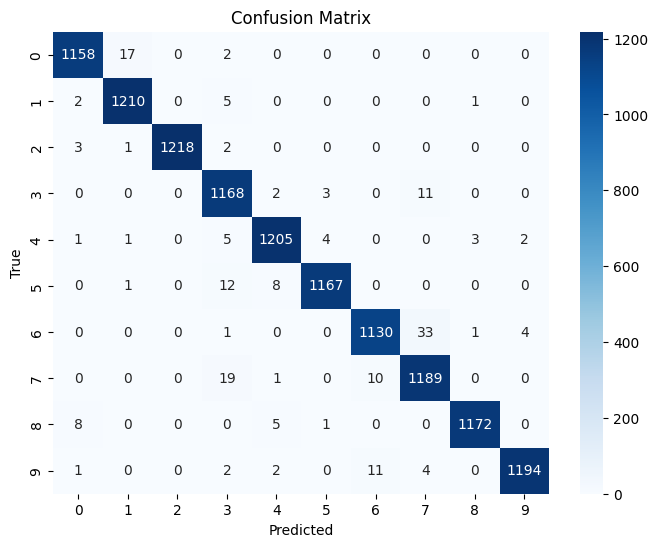

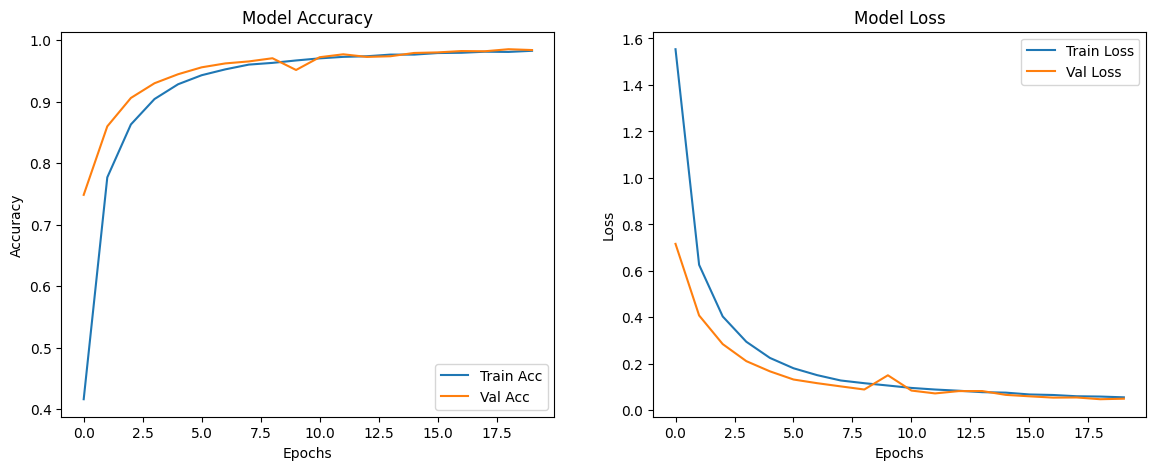

In [4]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Concatenate, GlobalAveragePooling2D, Activation, Input, Dropout, SeparableConv2D
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# --- 1. Data Loading and Preprocessing ---
print("Loading and preprocessing data...")

train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

X = train_df.drop('label', axis=1).values
y = train_df['label'].values
X_test_submission = test_df.drop('id', axis=1).values
test_ids = test_df['id'].values

X = X / 255.0
X_test_submission = X_test_submission / 255.0

X = X.reshape(-1, 28, 28, 1)
X_test_submission = X_test_submission.reshape(-1, 28, 28, 1)

X = tf.image.resize(X, (32, 32)).numpy()
X_test_submission = tf.image.resize(X_test_submission, (32, 32)).numpy()

X = np.repeat(X, 3, axis=-1)
X_test_submission = np.repeat(X_test_submission, 3, axis=-1)

y_categorical = to_categorical(y, num_classes=10)

X_train, X_val, y_train, y_val = train_test_split(
    X, y_categorical, test_size=0.2, random_state=42
)

print("Data preprocessing complete.")
print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")
print(f"Test submission data shape: {X_test_submission.shape}")

# --- 2. Build the SqueezeNetV2 Model Architecture ---
print("\nBuilding the SqueezeNetV2 model...")

def fire_module_v2(x, squeeze_filters, expand_filters):
    squeezed = Conv2D(squeeze_filters, (1, 1), activation='relu', padding='same')(x)
    expand_1x1 = Conv2D(expand_filters, (1, 1), activation='relu', padding='same')(squeezed)
    expand_3x3 = SeparableConv2D(expand_filters, (3, 3), activation='relu', padding='same')(squeezed)
    output = Concatenate(axis=-1)([expand_1x1, expand_3x3])
    return output

input_tensor = Input(shape=(32, 32, 3))
x = Conv2D(64, (3, 3), strides=(2, 2), padding='same', activation='relu')(input_tensor)
x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)

x = fire_module_v2(x, squeeze_filters=16, expand_filters=64)
x = fire_module_v2(x, squeeze_filters=16, expand_filters=64)
x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)

x = fire_module_v2(x, squeeze_filters=32, expand_filters=128)
x = fire_module_v2(x, squeeze_filters=32, expand_filters=128)
x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding='same')(x)

x = fire_module_v2(x, squeeze_filters=48, expand_filters=192)
x = fire_module_v2(x, squeeze_filters=48, expand_filters=192)

x = fire_module_v2(x, squeeze_filters=64, expand_filters=256)
x = Dropout(0.5)(x)

x = Conv2D(10, (1, 1), padding='same', activation='relu')(x)
x = GlobalAveragePooling2D()(x)
predictions = Activation('softmax')(x)

model = Model(inputs=input_tensor, outputs=predictions)

# --- 3. Compile the Model ---
print("\nCompiling the model...")
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

# --- 4. Train the Model ---
print("\nTraining the model...")

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-5)

history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=64,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

# --- 5. Evaluate Model Performance ---
print("\nEvaluating on validation set...")
val_loss, val_acc = model.evaluate(X_val, y_val, verbose=0)
print(f"Validation Accuracy: {val_acc:.4f}, Validation Loss: {val_loss:.4f}")

y_val_pred_probs = model.predict(X_val)
y_val_pred = np.argmax(y_val_pred_probs, axis=1)
y_val_true = np.argmax(y_val, axis=1)

print(f"\nValidation Accuracy Score: {accuracy_score(y_val_true, y_val_pred):.4f}")

print("\nClassification Report:")
print(classification_report(y_val_true, y_val_pred, digits=4))

cm = confusion_matrix(y_val_true, y_val_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), yticklabels=range(10))
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# --- 6. Plot Training Curves ---
plt.figure(figsize=(14,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()



4) EfficientNet-B0

Loading and preprocessing data...
Data preprocessing complete.
Training data shape: (48000, 32, 32, 3)
Validation data shape: (12000, 32, 32, 3)
Test data shape: (5000, 32, 32, 3)

Building the EfficientNet-B0 model...

Compiling and training (warmup)...
Epoch 1/5
750/750 [==============================] - 61s 73ms/step - loss: 2.3397 - accuracy: 0.1028 - val_loss: 2.3201 - val_accuracy: 0.0987 - lr: 0.0010
Epoch 2/5
750/750 [==============================] - 67s 89ms/step - loss: 2.3314 - accuracy: 0.1047 - val_loss: 2.3052 - val_accuracy: 0.1055 - lr: 0.0010
Epoch 3/5
750/750 [==============================] - 40s 53ms/step - loss: 2.3296 - accuracy: 0.1077 - val_loss: 2.3076 - val_accuracy: 0.1598 - lr: 0.0010
Epoch 4/5
750/750 [==============================] - 45s 60ms/step - loss: 2.3265 - accuracy: 0.1074 - val_loss: 2.3025 - val_accuracy: 0.0974 - lr: 0.0010
Epoch 5/5
750/750 [==============================] - 44s 59ms/step - loss: 2.3261 - accuracy: 0.1066 - val_loss: 2.3100 -

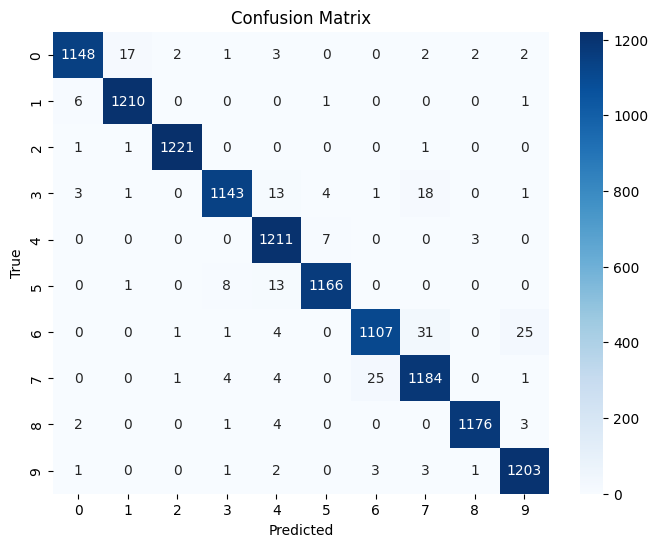

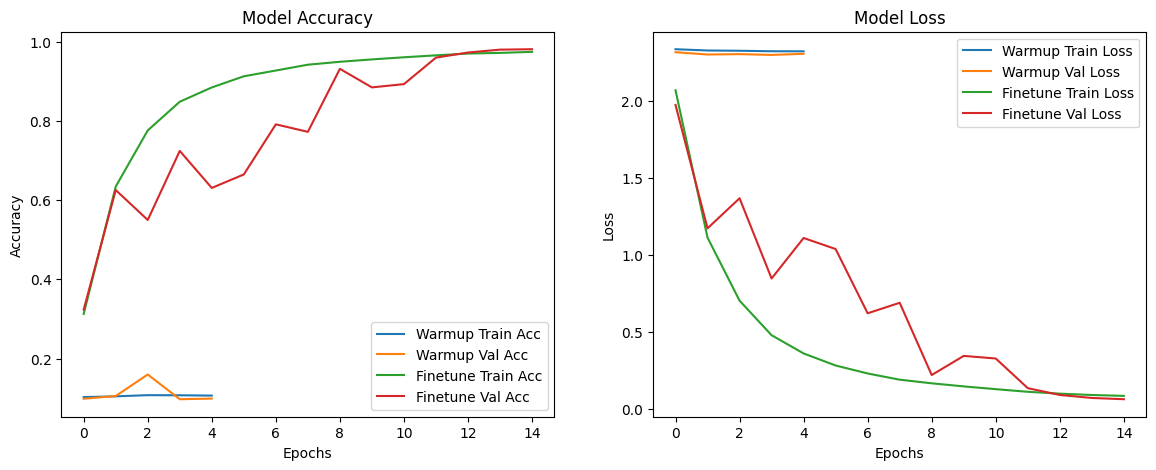

In [5]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# --- 1. Data Loading and Preprocessing ---
print("Loading and preprocessing data...")

train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

X = train_df.drop('label', axis=1).values
y = train_df['label'].values
X_test_submission = test_df.drop('id', axis=1).values
test_ids = test_df['id'].values

X = X / 255.0
X_test_submission = X_test_submission / 255.0

X = X.reshape(-1, 28, 28, 1)
X_test_submission = X_test_submission.reshape(-1, 28, 28, 1)

X = tf.image.resize(X, (32, 32)).numpy()
X_test_submission = tf.image.resize(X_test_submission, (32, 32)).numpy()

X = np.repeat(X, 3, axis=-1)
X_test_submission = np.repeat(X_test_submission, 3, axis=-1)

X_processed = preprocess_input(X)
X_test_submission_processed = preprocess_input(X_test_submission)

y_categorical = to_categorical(y, num_classes=10)

X_train, X_val, y_train, y_val = train_test_split(
    X_processed, y_categorical, test_size=0.2, random_state=42
)

print("Data preprocessing complete.")
print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")
print(f"Test data shape: {X_test_submission_processed.shape}")

# --- 2. Build Model ---
print("\nBuilding the EfficientNet-B0 model...")

input_shape = (32, 32, 3)
input_tensor = Input(shape=input_shape)

base_model = EfficientNetB0(include_top=False, weights='imagenet', input_tensor=input_tensor)
base_model.trainable = False  # freeze base initially

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
predictions = Dense(10, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# --- 3. Warmup Phase ---
print("\nCompiling and training (warmup)...")

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-5)

history = model.fit(
    X_train, y_train,
    epochs=5,
    batch_size=64,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

# --- 4. Fine-tuning Phase ---
print("\nUnfreezing base model for fine-tuning...")

base_model.trainable = True
# Optionally freeze first N layers to avoid overfitting
# for layer in base_model.layers[:200]:
#     layer.trainable = False

model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_finetune = model.fit(
    X_train, y_train,
    epochs=15,
    batch_size=64,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

# --- 5. Evaluate Model ---
print("\nEvaluating on validation set...")
val_loss, val_acc = model.evaluate(X_val, y_val, verbose=0)
print(f"Validation Accuracy: {val_acc:.4f}, Validation Loss: {val_loss:.4f}")

y_val_pred_probs = model.predict(X_val)
y_val_pred = np.argmax(y_val_pred_probs, axis=1)
y_val_true = np.argmax(y_val, axis=1)

print(f"\nValidation Accuracy Score: {accuracy_score(y_val_true, y_val_pred):.4f}")

print("\nClassification Report:")
print(classification_report(y_val_true, y_val_pred, digits=4))

cm = confusion_matrix(y_val_true, y_val_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), yticklabels=range(10))
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# --- 6. Plot Training Curves (Warmup + Fine-tune) ---
def plot_history(histories, titles):
    plt.figure(figsize=(14,5))
    
    # Accuracy
    plt.subplot(1,2,1)
    for h, label in histories:
        plt.plot(h.history['accuracy'], label=f'{label} Train Acc')
        plt.plot(h.history['val_accuracy'], label=f'{label} Val Acc')
    plt.title("Model Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    # Loss
    plt.subplot(1,2,2)
    for h, label in histories:
        plt.plot(h.history['loss'], label=f'{label} Train Loss')
        plt.plot(h.history['val_loss'], label=f'{label} Val Loss')
    plt.title("Model Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    
    plt.show()

plot_history([(history, "Warmup"), (history_finetune, "Finetune")], titles=["Accuracy","Loss"])



5) GoogleNet

Epoch 1/20
844/844 [==============================] - 258s 300ms/step - loss: 0.5318 - accuracy: 0.7965 - val_loss: 0.0556 - val_accuracy: 0.9855 - lr: 0.0010
Epoch 2/20
844/844 [==============================] - 211s 250ms/step - loss: 0.0544 - accuracy: 0.9862 - val_loss: 0.0507 - val_accuracy: 0.9883 - lr: 0.0010
Epoch 3/20
844/844 [==============================] - 213s 252ms/step - loss: 0.0403 - accuracy: 0.9897 - val_loss: 0.0313 - val_accuracy: 0.9922 - lr: 0.0010
Epoch 4/20
844/844 [==============================] - 210s 249ms/step - loss: 0.0354 - accuracy: 0.9916 - val_loss: 0.0579 - val_accuracy: 0.9862 - lr: 0.0010
Epoch 5/20
844/844 [==============================] - 209s 248ms/step - loss: 0.0341 - accuracy: 0.9912 - val_loss: 0.0327 - val_accuracy: 0.9910 - lr: 0.0010
Epoch 6/20
844/844 [==============================] - 208s 247ms/step - loss: 0.0306 - accuracy: 0.9920 - val_loss: 0.0513 - val_accuracy: 0.9892 - lr: 0.0010
Epoch 7/20
844/844 [==========================

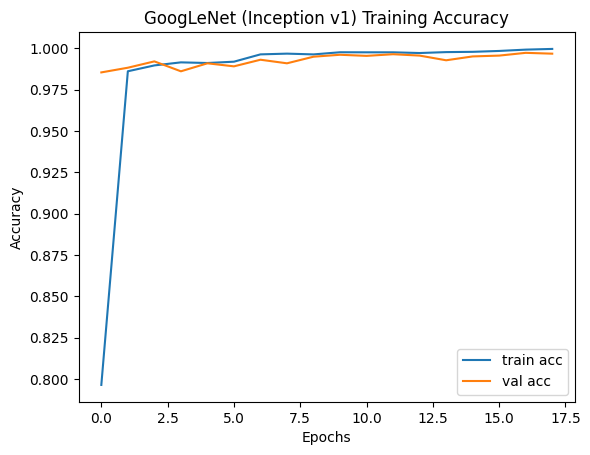

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten
from tensorflow.keras.layers import Input, Concatenate, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt

# --- 1. Load Dataset ---
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

X = train_df.iloc[:, 1:].values
y = train_df.iloc[:, 0].values
X_test = test_df.drop("id", axis=1).values

# --- 2. Preprocessing ---
X = X / 255.0
X_test = X_test / 255.0

X = X.reshape(-1, 28, 28, 1)
X_test = X_test.reshape(-1, 28, 28, 1)

X = np.repeat(X, 3, axis=-1)
X_test = np.repeat(X_test, 3, axis=-1)

X = tf.image.resize(X, (64, 64)).numpy()
X_test = tf.image.resize(X_test, (64, 64)).numpy()

y = to_categorical(y, num_classes=10)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)

# --- 3. Define GoogLeNet (Inception v1) ---
def inception_module(x, filters):
    f1, f3_in, f3_out, f5_in, f5_out, pool_proj = filters
    
    path1 = Conv2D(f1, (1,1), padding='same', activation='relu')(x)
    
    path2 = Conv2D(f3_in, (1,1), padding='same', activation='relu')(x)
    path2 = Conv2D(f3_out, (3,3), padding='same', activation='relu')(path2)
    
    path3 = Conv2D(f5_in, (1,1), padding='same', activation='relu')(x)
    path3 = Conv2D(f5_out, (5,5), padding='same', activation='relu')(path3)
    
    path4 = MaxPooling2D((3,3), strides=(1,1), padding='same')(x)
    path4 = Conv2D(pool_proj, (1,1), padding='same', activation='relu')(path4)
    
    return Concatenate()([path1, path2, path3, path4])

input_layer = Input(shape=(64,64,3))

x = Conv2D(64, (7,7), strides=(2,2), padding="same", activation="relu")(input_layer)
x = MaxPooling2D((3,3), strides=(2,2), padding="same")(x)

x = Conv2D(64, (1,1), padding="same", activation="relu")(x)
x = Conv2D(192, (3,3), padding="same", activation="relu")(x)
x = MaxPooling2D((3,3), strides=(2,2), padding="same")(x)

x = inception_module(x, [64, 96, 128, 16, 32, 32])
x = inception_module(x, [128, 128, 192, 32, 96, 64])
x = MaxPooling2D((3,3), strides=(2,2), padding="same")(x)

x = inception_module(x, [192, 96, 208, 16, 48, 64])
x = inception_module(x, [160, 112, 224, 24, 64, 64])
x = inception_module(x, [128, 128, 256, 24, 64, 64])
x = inception_module(x, [112, 144, 288, 32, 64, 64])
x = inception_module(x, [256, 160, 320, 32, 128, 128])
x = MaxPooling2D((3,3), strides=(2,2), padding="same")(x)

x = inception_module(x, [256, 160, 320, 32, 128, 128])
x = inception_module(x, [384, 192, 384, 48, 128, 128])

# ✅ Fixed block using GlobalAveragePooling2D
x = GlobalAveragePooling2D()(x)
x = Dropout(0.4)(x)
output_layer = Dense(10, activation="softmax")(x)

model = Model(inputs=input_layer, outputs=output_layer)

# --- 4. Compile ---
model.compile(optimizer=Adam(learning_rate=0.001),
              loss="categorical_crossentropy",
              metrics=["accuracy"])

# --- 5. Train ---
early_stop = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=64,
    callbacks=[early_stop, reduce_lr]
)

# --- 6. Evaluate ---
val_loss, val_acc = model.evaluate(X_val, y_val, verbose=0)
print(f"Validation Accuracy: {val_acc*100:.2f}%")

# --- 7. Plot Training History ---
plt.plot(history.history["accuracy"], label="train acc")
plt.plot(history.history["val_accuracy"], label="val acc")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("GoogLeNet (Inception v1) Training Accuracy")
plt.show()



Validation Accuracy: 98.08%


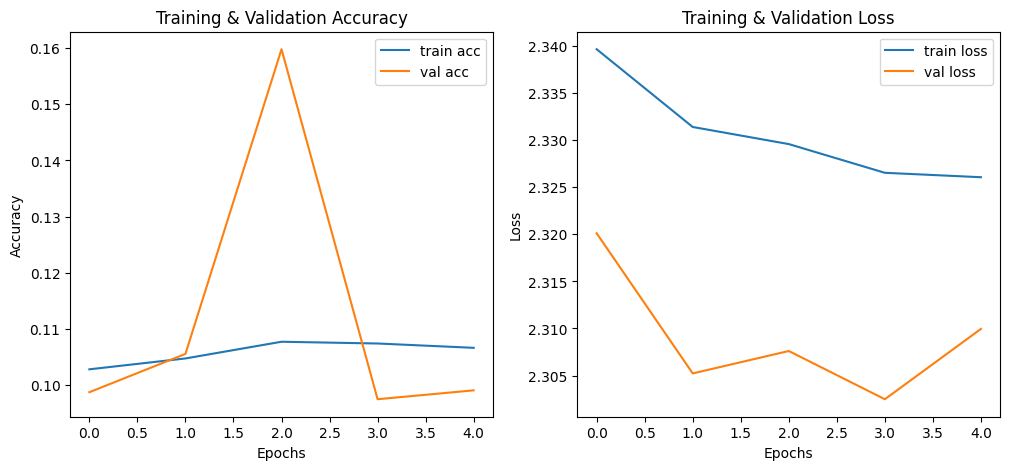

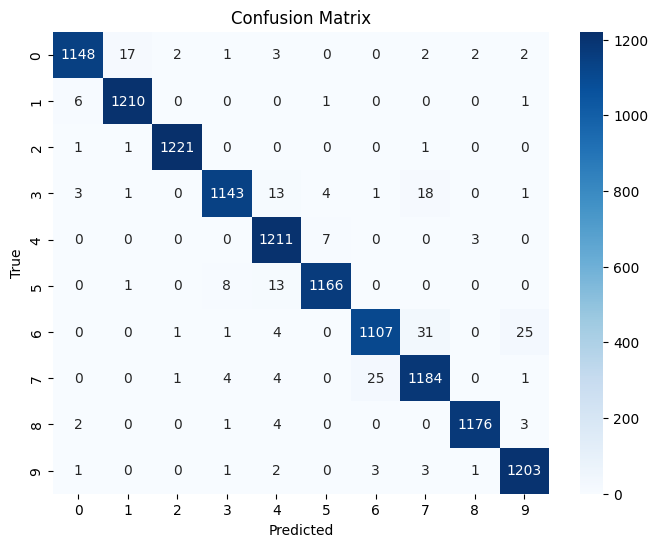


Classification Report:
              precision    recall  f1-score   support

           0     0.9888    0.9754    0.9820      1177
           1     0.9837    0.9934    0.9886      1218
           2     0.9967    0.9975    0.9971      1224
           3     0.9862    0.9654    0.9757      1184
           4     0.9657    0.9918    0.9786      1221
           5     0.9898    0.9815    0.9856      1188
           6     0.9745    0.9470    0.9605      1169
           7     0.9556    0.9713    0.9634      1219
           8     0.9949    0.9916    0.9932      1186
           9     0.9733    0.9909    0.9820      1214

    accuracy                         0.9808     12000
   macro avg     0.9809    0.9806    0.9807     12000
weighted avg     0.9809    0.9808    0.9807     12000



In [6]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# --- 6. Evaluate ---
val_loss, val_acc = model.evaluate(X_val, y_val, verbose=0)
print(f"Validation Accuracy: {val_acc*100:.2f}%")

# --- 7. Training History Plots ---
plt.figure(figsize=(12,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history.history["accuracy"], label="train acc")
plt.plot(history.history["val_accuracy"], label="val acc")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training & Validation Accuracy")

# Loss
plt.subplot(1,2,2)
plt.plot(history.history["loss"], label="train loss")
plt.plot(history.history["val_loss"], label="val loss")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")

plt.show()

# --- 8. Performance Metrics ---
# Predictions
y_val_pred = model.predict(X_val, verbose=0)
y_val_pred_classes = np.argmax(y_val_pred, axis=1)
y_val_true = np.argmax(y_val, axis=1)

# Confusion Matrix
cm = confusion_matrix(y_val_true, y_val_pred_classes)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
            xticklabels=[str(i) for i in range(10)], 
            yticklabels=[str(i) for i in range(10)])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Classification Report
print("\nClassification Report:")
print(classification_report(y_val_true, y_val_pred_classes, digits=4))


6) VGG16

Loading and preprocessing data...
Data preprocessing complete.
Training data shape: (48000, 32, 32, 3)
Validation data shape: (12000, 32, 32, 3)
Test data shape: (5000, 32, 32, 3)

Building the VGG16 model...
58889256/58889256 [==============================] - 5s 0us/step

Compiling and training...
Epoch 1/15
750/750 [==============================] - 88s 116ms/step - loss: 2.5324 - accuracy: 0.2161 - val_loss: 1.8817 - val_accuracy: 0.5306 - lr: 0.0010
Epoch 2/15
750/750 [==============================] - 95s 126ms/step - loss: 1.8777 - accuracy: 0.3420 - val_loss: 1.6878 - val_accuracy: 0.5096 - lr: 0.0010
Epoch 3/15
750/750 [==============================] - 94s 125ms/step - loss: 1.7813 - accuracy: 0.3763 - val_loss: 1.5635 - val_accuracy: 0.6043 - lr: 0.0010
Epoch 4/15
750/750 [==============================] - 93s 124ms/step - loss: 1.7359 - accuracy: 0.3876 - val_loss: 1.4852 - val_accuracy: 0.6300 - lr: 0.0010
Epoch 5/15
750/750 [==============================] - 94s 125ms/ste

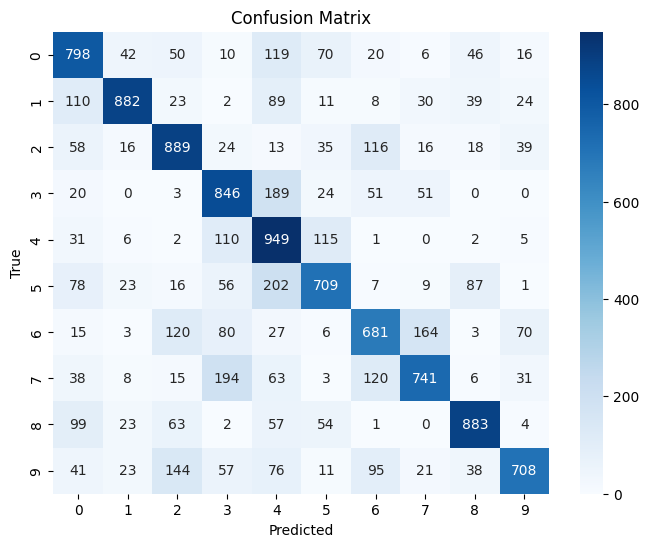

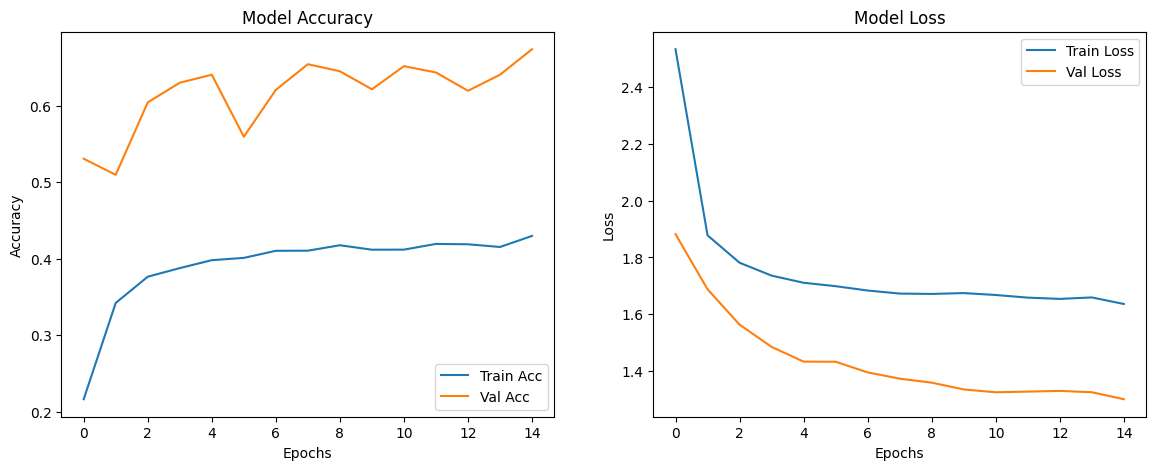


Generating predictions on the test set and creating submission file...
157/157 [==============================] - 9s 57ms/step
Submission file saved as submission.csv


In [7]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# --- 1. Data Loading and Preprocessing ---
print("Loading and preprocessing data...")

train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

X = train_df.drop('label', axis=1).values
y = train_df['label'].values
X_test_submission = test_df.drop('id', axis=1).values
test_ids = test_df['id'].values

# Normalize
X = X / 255.0
X_test_submission = X_test_submission / 255.0

# Reshape
X = X.reshape(-1, 28, 28, 1)
X_test_submission = X_test_submission.reshape(-1, 28, 28, 1)

# Resize to 32x32
X = tf.image.resize(X, (32, 32)).numpy()
X_test_submission = tf.image.resize(X_test_submission, (32, 32)).numpy()

# Convert grayscale → RGB
X = np.repeat(X, 3, axis=-1)
X_test_submission = np.repeat(X_test_submission, 3, axis=-1)

# Preprocess for VGG16
X_processed = preprocess_input(X)
X_test_submission_processed = preprocess_input(X_test_submission)

# One-hot encode labels
y_categorical = to_categorical(y, num_classes=10)

# Train-validation split
X_train, X_val, y_train, y_val = train_test_split(
    X_processed, y_categorical, test_size=0.2, random_state=42
)

print("Data preprocessing complete.")
print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")
print(f"Test data shape: {X_test_submission_processed.shape}")

# --- 2. Build Model ---
print("\nBuilding the VGG16 model...")

input_shape = (32, 32, 3)
input_tensor = Input(shape=input_shape)

base_model = VGG16(include_top=False, weights='imagenet', input_tensor=input_tensor)

# Freeze base model for transfer learning
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
predictions = Dense(10, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# --- 3. Compile & Train ---
print("\nCompiling and training...")

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-5)

history = model.fit(
    X_train, y_train,
    epochs=15,
    batch_size=64,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

# --- 4. Evaluate Model ---
print("\nEvaluating on validation set...")
val_loss, val_acc = model.evaluate(X_val, y_val, verbose=0)
print(f"Validation Accuracy: {val_acc:.4f}, Validation Loss: {val_loss:.4f}")

y_val_pred_probs = model.predict(X_val)
y_val_pred = np.argmax(y_val_pred_probs, axis=1)
y_val_true = np.argmax(y_val, axis=1)

print(f"\nValidation Accuracy Score: {accuracy_score(y_val_true, y_val_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_val_true, y_val_pred, digits=4))

cm = confusion_matrix(y_val_true, y_val_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), yticklabels=range(10))
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# --- 5. Plot Training Curves ---
plt.figure(figsize=(14,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()

# --- 6. Generate Submission File ---
print("\nGenerating predictions on the test set and creating submission file...")
y_pred_probs = model.predict(X_test_submission_processed)
y_pred_labels = np.argmax(y_pred_probs, axis=1)

submission = pd.DataFrame({'id': test_ids, 'label': y_pred_labels})
submission.to_csv("submission.csv", index=False)
print("Submission file saved as submission.csv")
